##  IBM Data Science Professional Certificate Capstone - Vikas Sharma

### 1. Import relevant libraries

In [143]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt # library to plot visualizations
import folium # map rendering library
import json # library to handle JSON files
import geocoder # to get coordinates
import time # to use a timer
from IPython.display import Image # to render images of the maps created
import requests # library to handle requests

print('Success! - All libraries imported.')

Success! - All libraries imported.


### 2. Download data on Singapore townships 

#### Source - https://data.gov.sg/dataset/estimated-resident-population-living-in-hdb-flats?resource_id=b29c1af8-e11a-4e61-b813-933db9f69633

Data was downloaded from the above source site in CSV format and saved on local disk as 'SGTownData.csv'

### 3. Exploring and cleaning the township data 

In [144]:
#reading the csv file into a Pandas dataframe named 'towndata' and checking the first 5 rows
towndata = pd.read_csv('D:/Coursera/Capstone/Data/SGTowndata.csv')
towndata.head()

,financial_year,town_or_estate,population
0,2008,Ang Mo Kio,148200
1,2008,Bedok,197900
2,2008,Bishan,66500
3,2008,Bukit Batok,109100
4,2008,Bukit Merah,140600


In [145]:
towndata['financial_year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype=int64)

We see that the dataframe has historical information on the town population from 2008 to 2018. We will need to use only the latest information, so only information for year 2018 is retained in a new dataframe named 'df'. We see that df has 26 rows, with each row representing one town

In [146]:
df = towndata[towndata['financial_year']==2018] #select only information for 2018
df = df.reset_index().drop(columns=['index'])   #reset index to start from 0
df.shape

(26, 3)

In [147]:
df

,financial_year,town_or_estate,population
0,2018,Ang Mo Kio,141600
1,2018,Bedok,191300
2,2018,Bishan,62100
3,2018,Bukit Batok,115200
4,2018,Bukit Merah,144300
5,2018,Bukit Panjang,120100
6,2018,Bukit Timah,8300
7,2018,Central Area,27300
8,2018,Choa Chu Kang,168500
9,2018,Clementi,71900


Now that we have the latest information in df, we drop the column 'financial_year' and also rename the column 'town_or_estate' to 'town' for ease of reference

In [148]:
df = df.drop(columns=['financial_year'])
df = df.rename(columns={'town_or_estate':'Town'})

As per John's specifications, we only retain those towns for consideration that have above median population

In [149]:
df = df[df['population']>df['population'].median()] #select only those towns that have > median population
df = df.reset_index().drop(columns='index')         #reset index to start from 0

##### We end up with our cleaned and processed dataframe that has the names of the 13 candidate towns for further consideration. We make a copy of it and name it df2. We can now also drop the column 'population' because it is not relevant for further analysis

In [150]:
df2 = df.copy()

df2 = df2.drop(columns=['population'])

#our cleaned and proceesed dataframe for further analysis
df2

,Town
0,Ang Mo Kio
1,Bedok
2,Bukit Batok
3,Bukit Merah
4,Bukit Panjang
5,Choa Chu Kang
6,Hougang
7,Jurong West
8,Punggol
9,Sengkang


### 4. Getting geographical coordinates for the towns 

Using the ArcGIS system, latitude and longitude coordinates are extracted for each of the 13 towns, and added to two lists named 'latlist' (for latitude information) and 'longlist' for longitude information. Since geocoding can be a time-consuming process, we also initiate a timer to check how long the entire geocoding process takes.

In [151]:
#intiate lists to hold the latitude and longitude coordinates
latlist = []
longlist = []

start = time.time() #start timer

#loop through each row of our town dataframe and geocode each town, adding the information to latlist and longlist
for i in range(0,df2.shape[0]):
    town_name = df2.iloc[i,0]
    g = geocoder.arcgis('{},Singapore'.format(town_name))
    latlist.append(g.latlng[0])
    longlist.append(g.latlng[1])

end = time.time() #stop timer

print('All towns geocoded successfully!')
print('Time taken -->',round((end-start),2),'seconds')

All towns geocoded successfully!
Time taken --> 17.03 seconds


The latitude and longitude information extracted above is added to our town dataframe as two new columns

In [152]:
df2['Latitude'] = latlist
df2['Longitude'] = longlist

We then check the first 5 rows of the dataframe to check that the coordinate information has been successfully added

In [153]:
df2.head()

,Town,Latitude,Longitude
0,Ang Mo Kio,1.37161,103.84546
1,Bedok,1.32425,103.95297
2,Bukit Batok,1.34952,103.75277
3,Bukit Merah,1.28417,103.82306
4,Bukit Panjang,1.37877,103.76977


To get a visual understanding of where these towns are in Singapore, we plot them on a map of Singapore using the folium library

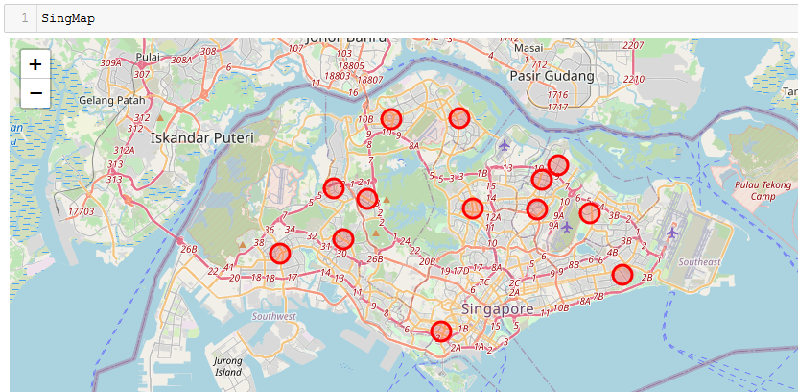

In [154]:
#geocode Singapore using ArcGIS and capture the coordinates in Singloc
g = geocoder.arcgis('Singapore')
Singloc = g.latlng 

#initiate a map object with Singapore's location (Singloc) using the folium library and name the map SingMap
SingMap = folium.Map(location=Singloc, zoom_start=11) 

#loop through each row of our town dataframe and add markers on SingMap for each town using folium's CircleMarker
for i in range(0,df2.shape[0]):
    label = df2.iloc[i,0]
    label = folium.Popup(label,parse_html=True)
    loc = [df2.iloc[i,1],df2.iloc[i,2]]
    
    x = folium.CircleMarker(
        location=loc,
        color='red',
        popup=label,
        fill=True,
        parse_html=False)
    
    x.add_to(SingMap)

# plot the map
#SingMap #uncomment when running code on own system. Here, we are using a screenshot of the map instead for ease of visibility when uploading on Github

Image(filename='D:/Coursera/Capstone/SingMap.png')

### 5. Using the FourSquare API to get information on venues and amenities in the towns

First we define our Foursquare credentials and version for use

In [155]:
CLIENT_ID = '2H24FOUBCPRJ3TXRU5BEJWKE3FZDH3XWLTE3C1BALYUFEMB3' # your Foursquare ID
CLIENT_SECRET = 'GSTDO022WJTUHKQJJEUDC33Z5LWRB3HXBY3OJI5OPYH5TGEV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ',CLIENT_ID)
print('CLIENT_SECRET:',CLIENT_SECRET)

Your credentails:
CLIENT_ID:  2H24FOUBCPRJ3TXRU5BEJWKE3FZDH3XWLTE3C1BALYUFEMB3
CLIENT_SECRET: GSTDO022WJTUHKQJJEUDC33Z5LWRB3HXBY3OJI5OPYH5TGEV


As per John's initial specifications, we restrict our exploring radius to within 1km, i.e. 1000 m. Also, we limit the number of results for each venue to 100. 

In [156]:
radius = 1000
LIMIT = 100

We now loop through all the towns, creating a API request URL for each, getting the response from Foursquare API, and storing relevant venue information in a list called 'venuelist'. We also initiate a timer to check how long this process takes

In [157]:
venuelist = [] #masterlist to contain information on all venues from all towns

start = time.time() #start timer

for i in range(0,df2.shape[0]):
    town = df2.iloc[i,0]
    lat = df2.iloc[i,1]
    long = df2.iloc[i,2]
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request and get information on the venues 
    get_response = requests.get(url).json()
    results = get_response['response']['groups'][0]['items'] 

    
    #collect only the relevant information for each venue (in this case, we only extract name of venue and its category)
    for venue in results:
        name = venue['venue']['name']
        category = venue['venue']['categories'][0]['name']
        venuelist.append([town,name,category])

end = time.time() #stop timer

print('Venue information for all towns extracted successfully from Foursquare!')
print('Time taken -->',round((end-start),2),'seconds')

Venue information for all towns extracted successfully from Foursquare!
Time taken --> 23.38 seconds


Each element in the list venues represents a venue and contains information on the - town, venue's name, and venue's category. We check the first 5 elements of the list venues to confirm that it has been populated correctly

In [158]:
venuelist[0:5]

[['Ang Mo Kio', 'NTUC FairPrice', 'Supermarket'],
 ['Ang Mo Kio', 'Face Ban Mian 非板面 (Ang Mo Kio)', 'Noodle House'],
 ['Ang Mo Kio', 'Kam Jia Zhuang Restaurant', 'Asian Restaurant'],
 ['Ang Mo Kio', 'Old Chang Kee', 'Snack Place'],
 ['Ang Mo Kio', 'MOS Burger', 'Burger Joint']]

The venues list seems to have been populated correctly! Now, we check the length of the list venues to see how many total venues have been added to it

In [159]:
num_venues = len(venuelist)
print('A total of',num_venues,'venues have been added from the towns')

A total of 787 venues have been added from the towns


### 6. Analyzing the Foursquare data for the towns to arrive at our optimum town selection

We first create a pandas DataFrame (let's call it mydf) from the venueslist, with each row representing one venue, and 3 columns (one each for town name, venue name, and venue category)

In [160]:
townlist=[] 
namelist=[]
catlist=[]

#loop through venueslist and extract town name, venue name, and category, adding them to the three lists initiated above
for i in range(0,len(venuelist)):
    townlist.append(venuelist[i][0])
    namelist.append(venuelist[i][1])
    catlist.append(venuelist[i][2])

#create empty dataframe mydf and add columns for Town, Name, and Category to it   
mydf = pd.DataFrame()    
mydf['Town'] = townlist
mydf['Name'] = namelist
mydf['Category'] = catlist

We check the shape of mydf to confirm that the number of rows is same as total number of venues (i.e. len(venuelist)

In [161]:
if(mydf.shape[0]==len(venuelist)):
    print('Success! Dataframe has the correct number of rows')
else:
    print('Failure. Please check')

Success! Dataframe has the correct number of rows


We also check the first 5 rows of mydf to confirm that the data has loaded correctly

In [162]:
mydf.head()

,Town,Name,Category
0,Ang Mo Kio,NTUC FairPrice,Supermarket
1,Ang Mo Kio,Face Ban Mian 非板面 (Ang Mo Kio),Noodle House
2,Ang Mo Kio,Kam Jia Zhuang Restaurant,Asian Restaurant
3,Ang Mo Kio,Old Chang Kee,Snack Place
4,Ang Mo Kio,MOS Burger,Burger Joint


We check to see how many unique venue categories exist in our dataframe

In [163]:
num_categories = mydf['Category'].unique().size
print('There are',num_categories,'unique venue categories across the towns')

There are 145 unique venue categories across the towns


We create a pivot table (let's call it 'piv') from mydf to see how many venues of each category exist for each town

In [164]:
piv = pd.pivot_table(mydf,index='Town',columns='Category',aggfunc=np.size,fill_value=0) 
#aggfunc=np.size is used to get the number of venues for each category

piv

Name                             \
Category      Accessories Store American Restaurant Arcade   
Town                                                         
Ang Mo Kio                    0                   0      0   
Bedok                         0                   1      0   
Bukit Batok                   0                   0      0   
Bukit Merah                   0                   0      0   
Bukit Panjang                 1                   1      0   
Choa Chu Kang                 0                   0      0   
Hougang                       0                   0      0   
Jurong West                   0                   1      0   
Punggol                       0                   0      0   
Sengkang                      0                   0      0   
Tampines                      0                   0      0   
Woodlands                     0                   0      0   
Yishun                        0                   0      1   

                                                                        \
Category      Arts & Entertainment Asian Restaurant Athletics & Sports   
Town                                                                     
Ang Mo Kio                       0                3                  0   
Bedok                            0                2                  0   
Bukit Batok                      1                0                  0   
Bukit Merah                      0                1                  0   
Bukit Panjang                    0                3                  0   
Choa Chu Kang                    0                2                  0   
Hougang                          0                3                  1   
Jurong West                      0                6                  0   
Punggol                          0                2                  1   
Sengkang                         0                1                  0   
Tampines                         0                0                  1   
Woodlands                        0                1                  0   
Yishun                           0                3                  0   

                                         ...                               \
Category      BBQ Joint Bakery Bank Bar  ... Tennis Court Thai Restaurant   
Town                                     ...                                
Ang Mo Kio            0      1    1   0  ...            0               1   
Bedok                 1      0    0   0  ...            0               0   
Bukit Batok           0      0    0   0  ...            0               0   
Bukit Merah           0      3    0   1  ...            0               0   
Bukit Panjang         1      1    0   0  ...            0               0   
Choa Chu Kang         0      1    0   0  ...            0               1   
Hougang               0      1    0   0  ...            0               1   
Jurong West           0      0    0   0  ...            0               0   
Punggol               0      1    0   0  ...            0               0   
Sengkang              0      1    0   0  ...            0               0   
Tampines              0      0    0   0  ...            0               0   
Woodlands             1      0    0   0  ...            1               2   
Yishun                0      0    0   0  ...            0               1   

                                                                 \
Category      Track Train Station Vegetarian / Vegan Restaurant   
Town                                                              
Ang Mo Kio        0             0                             3   
Bedok             0             0                             0   
Bukit Batok       1             0                             0   
Bukit Merah       0             1                             1   
Bukit Panjang     0             0                             0   
Choa Chu Kang     0             0                             0   
Hougang      

We use the 'droplevel' function to change the columns from multilevel to single-level for easier manipulation

In [165]:
piv.columns = piv.columns.droplevel(0)

piv

Category,Accessories Store,American Restaurant,Arcade,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,...,Tennis Court,Thai Restaurant,Track,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Yoga Studio
Town,,,,,,,,,,,,,,,,,,,,,
Ang Mo Kio,0,0,0,0,3,0,0,1,1,0,...,0,1,0,0,3,0,0,0,0,0
Bedok,0,1,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bukit Batok,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bukit Merah,0,0,0,0,1,0,0,3,0,1,...,0,0,0,1,1,0,0,0,0,1
Bukit Panjang,1,1,0,0,3,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Choa Chu Kang,0,0,0,0,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
Hougang,0,0,0,0,3,1,0,1,0,0,...,0,1,0,0,2,0,0,0,0,0
Jurong West,0,1,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Punggol,0,0,0,0,2,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


From initial specifications given by John, we know that the venues/amenities of interest to him and his family are the following - 'Multiplex','Supermarket','Shopping Mall','Playground','Bubble Tea Shop'. So we delete all other venue categories from our pivot table and only retain our focus categories. We rename this new pivot table as 'piv2'

In [166]:
piv2 = piv.loc[:,['Multiplex','Supermarket','Shopping Mall','Playground','Bubble Tea Shop']]

piv2

Category,Multiplex,Supermarket,Shopping Mall,Playground,Bubble Tea Shop
Town,,,,,
Ang Mo Kio,1,2,1,0,2
Bedok,0,1,0,1,0
Bukit Batok,1,0,1,0,0
Bukit Merah,0,2,0,0,1
Bukit Panjang,0,1,3,1,0
Choa Chu Kang,0,1,0,1,1
Hougang,0,2,2,1,0
Jurong West,1,1,2,1,1
Punggol,1,3,1,0,1


From the initial specifications, we know that the key decision metric is the presence (or not) of focus venue categories in the town, NOT the number of venues of the focus venue categories. So, we do a binary coding:

'1'= town has one or more venues of a focus category
'0'= town has zero venues of a focus category

In [167]:
#binary coding of the pivot table piv2

for i in range(0,piv2.shape[0]):
    for j in range(0,piv2.shape[1]):
        if(piv2.iloc[i,j]>0):
            piv2.iloc[i,j] = 1
            
#binary coded pivot table piv2
piv2

Category,Multiplex,Supermarket,Shopping Mall,Playground,Bubble Tea Shop
Town,,,,,
Ang Mo Kio,1,1,1,0,1
Bedok,0,1,0,1,0
Bukit Batok,1,0,1,0,0
Bukit Merah,0,1,0,0,1
Bukit Panjang,0,1,1,1,0
Choa Chu Kang,0,1,0,1,1
Hougang,0,1,1,1,0
Jurong West,1,1,1,1,1
Punggol,1,1,1,0,1


Now that we have all relevant information, we calculate a weighted score for each town. We employ the weights that were decided on in the initial specifications given by John:

Weight(Multiplex) = 0.40
Weight(Supermarket)=0.25
Weight(Shopping Mall) = 0.05
Weight(Playground) = 0.20
Weight(Bubble Tea Shop) = 0.10

In [168]:
#add a new column 'Score' to piv2 that holds the weighted score for each town based on the weights specified for each focus category

piv2['Score'] = piv2['Multiplex']*0.4+ \
                piv2['Supermarket']*0.25+ \
                piv2['Shopping Mall']*0.05+ \
                piv2['Playground']*0.2+ \
                piv2['Bubble Tea Shop']*0.1

#display the dataframe piv2, with values sorted on Score in descending order
piv2 = piv2.sort_values(by='Score',ascending=False)
piv2

Category,Multiplex,Supermarket,Shopping Mall,Playground,Bubble Tea Shop,Score
Town,,,,,,
Jurong West,1,1,1,1,1,1.00
Ang Mo Kio,1,1,1,0,1,0.80
Punggol,1,1,1,0,1,0.80
Yishun,1,1,1,0,1,0.80
Choa Chu Kang,0,1,0,1,1,0.55
Bukit Panjang,0,1,1,1,0,0.50
Hougang,0,1,1,1,0,0.50
Tampines,0,1,1,1,0,0.50
Bedok,0,1,0,1,0,0.45


### From the table, we can see that 'Jurong West' has the highest weighted score and should be chosen as the optimum town selection by John and his family. 

We also plot the scores to see a visual representation of the optimum town selection

<function matplotlib.pyplot.show(*args, **kw)>

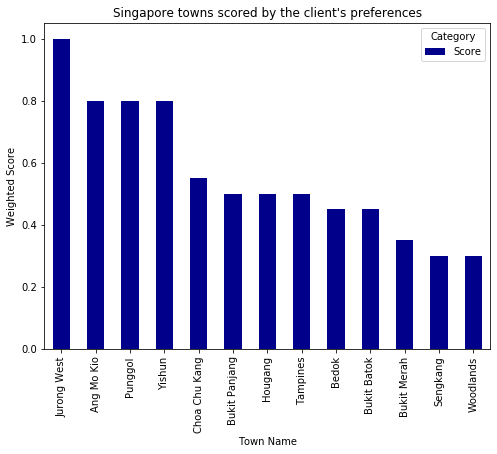

In [169]:
piv2[['Score']].plot(kind='bar',figsize=(8,6),color='DarkBlue')
plt.xlabel('Town Name')
plt.ylabel('Weighted Score')
plt.title('Singapore towns scored by the client\'s preferences')
plt.show

For good measure, we also highlight the optimum town selection by plotting it on Singapore's map, centering the map on the optimum town and placing a Red marker on the optimum town

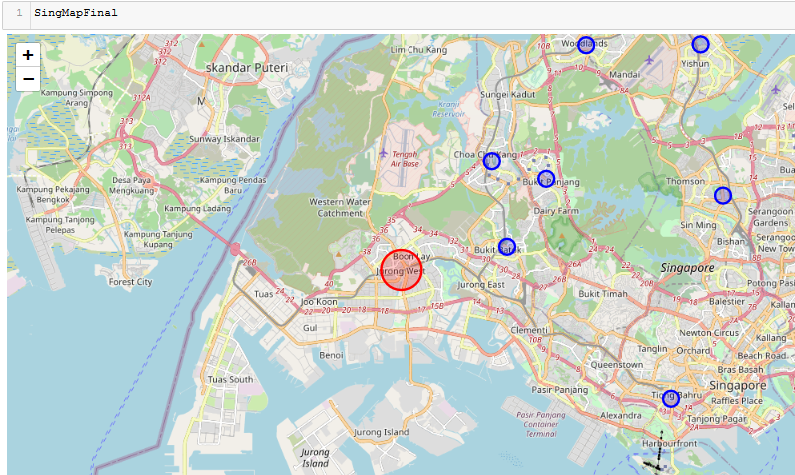

In [171]:
chosentown = piv2.index[0]


chosentownloc = geocoder.arcgis('{},Singapore'.format(chosentown)).latlng

SingMapFinal = folium.Map(location=chosentownloc, zoom_start=12) 

for i in range(0,df2.shape[0]):
    label = df2.iloc[i,0]
    label = folium.Popup(label,parse_html=True)
    loc = [df2.iloc[i,1],df2.iloc[i,2]]
    
    if(df2.iloc[i,0] == chosentown):
        x = folium.CircleMarker(
        location=loc,
        color='red',
        popup=label,
        radius = 25,
        fill=True,
        fillopacity=0.7,
        parse_html=False)
        x.add_to(SingMapFinal)
                 
    else:
        x = folium.CircleMarker(
        location=loc,
        color='blue',
        popup=label,
        fill=True,
        parse_html=False)
        x.add_to(SingMapFinal)
        
# plot the map
#SingMapFinal #uncomment when running code on own system. Here, we are using a screenshot of the map instead for ease of visibility when uploading on Github

Image(filename='D:/Coursera/Capstone/SingMapFinal.png')